Code inspired by this website : 

https://www.datacamp.com/community/tutorials/generative-adversarial-networks

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
# !pip install pyimgur

     |████████████████████████████████| 332.1MB 73kB/s 
     |████████████████████████████████| 61kB 25.6MB/s 
     |████████████████████████████████| 419kB 26.1MB/s 
     |████████████████████████████████| 3.0MB 37.5MB/s 


In [2]:
# First, let's load our dataset : MNIST
from keras.datasets import mnist

(X_train, y_train), (_, _) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# Normalizing the data so it takes values between -1 and 1

X_train = X_train / 127.5 - 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [0]:
# Alterable variables

NOISE_DIM = 100
LEARNING_RATE = 0.0002
BETA = 0.5
EPOCHS = 150
BATCH_SIZE = 64

# Non-alterable variables

batch_count = X_train.shape[0] // 128
num_categories = len(set(y_train.reshape(y_train.shape[0])))
num_examples_to_generate = 3*num_categories

In [0]:
# Constructing the generator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Reshape, Flatten
from tensorflow.keras.optimizers import Adam

gen_input = Input(shape=(NOISE_DIM,))

hid = Dense(256)(gen_input)
hid = Activation("relu")(hid)
hid = Dense(512)(hid)
hid = Activation("relu")(hid)
hid = Dense(1024)(hid)
hid = Activation("relu")(hid)
hid = Dense(28*28)(hid)
hid = Activation("tanh")(hid)

gen_output = Reshape((28, 28, 1))(hid)

generator = Model(inputs=gen_input, outputs=gen_output)

generator.compile(loss="binary_crossentropy", optimizer=Adam(lr=LEARNING_RATE, beta_1=BETA))

In [0]:
# Constructing the discriminator

disc_input = Input(shape=(28, 28, 1))

hid = Flatten()(disc_input)
hid = Dense(1024)(hid)
hid = Activation("relu")(hid)
hid = Dense(512)(hid)
hid = Activation("relu")(hid)
hid = Dense(256)(hid)
hid = Activation("relu")(hid)
hid = Dense(1)(hid)
disc_output = Activation("sigmoid")(hid)

discriminator = Model(inputs=disc_input, outputs=disc_output)

discriminator.compile(loss="binary_crossentropy", optimizer=Adam(lr=LEARNING_RATE, beta_1=BETA))


In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)

gan.compile(loss="binary_crossentropy", optimizer=Adam(lr=LEARNING_RATE, beta_1=BETA))


In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

def generate_and_save_images(model, epoch, test_input, all_gen_loss, all_disc_loss):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
#     print("test_input : ", test_input)
#     print("conditions : ", conditions)
    gen_imgs = model(test_input, training=False)

#     fig = plt.figure(1, figsize=(4,4))

#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow((predictions[i]+1)/2)#, cmap='rgb')
#         plt.axis('off')
#     plt.savefig('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch))
    
    plt.figure(1)
    fig, axs = plt.subplots(5, 6, figsize=(num_categories, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(num_categories):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i + 3*classlabel], scale=True)
            axs[row,i+coloffset].imshow(img, cmap='gray')
            axs[row,i+coloffset].axis('off')
#     plt.savefig('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch))
    
    plt.figure(1000)
    plt.plot(all_gen_loss)
    plt.plot(all_disc_loss)
#     plt.savefig('imgs' + os.sep + 'cdcgan_cifar10' + os.sep + 'graph_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
from tensorflow.random import normal
from tensorflow import one_hot
from math import floor

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = normal([num_examples_to_generate, NOISE_DIM])

<Figure size 432x288 with 0 Axes>

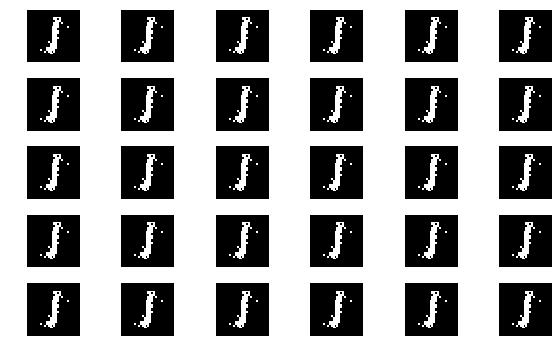

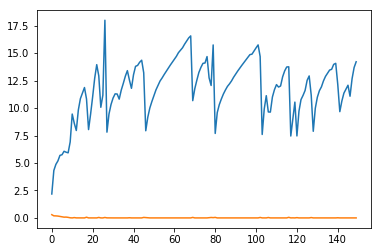


Time for epoch n°150/150 : 7.333373785018921 seconds
Generator loss :  14.208387
Discriminator loss :  4.777341e-07


In [10]:
from tqdm import tqdm
import numpy as np
from IPython import display
import time

all_gen_loss = []
all_disc_loss = []

# epochs = 100
# batch_size = 10
for e in range(1, EPOCHS+1):
    start = time.time()
    
    temp_gen_loss = []
    temp_disc_loss = []
    for _ in tqdm(range(batch_count)):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, NOISE_DIM])
        image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]

        # Generate fake MNIST images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*BATCH_SIZE)
        # One-sided label smoothing
        y_dis[:BATCH_SIZE] = 1

        # Train discriminator
        discriminator.trainable = True
        disc_loss = discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gen = np.ones(BATCH_SIZE)
        discriminator.trainable = False
        gen_loss = gan.train_on_batch(noise, y_gen)
        
        temp_gen_loss.append(gen_loss)
        temp_disc_loss.append(disc_loss)
        

#     if e == 1 or e % 5 == 0:
#         plot_generated_images(e, generator)
    all_gen_loss.append(np.mean(temp_gen_loss))
    all_disc_loss.append(np.mean(temp_disc_loss))
    display.clear_output(wait=True)
    generate_and_save_images(generator, EPOCHS, seed, all_gen_loss, all_disc_loss)
    print("\nTime for epoch n°" + str(e) + "/" + str(EPOCHS) + " : " + str(time.time() - start) + " seconds")
    print("Generator loss : ", all_gen_loss[-1])
    print("Discriminator loss : ", all_disc_loss[-1])